In [10]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import numpy as np
import tensorflow as tf
from basenji import seqnn, stream

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_1hot
from akita_utils.seq_gens import symmertic_insertion_seqs_gen
from akita_utils.numpy_utils import ut_dense
from akita_utils.tsv_utils import (
    add_orientation,
    add_background
)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# arguments 
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

# tsv with coordinates of 10 strong sites randomly chosed from the first 4 percentiles (wrt insertion score)
CTCT_table = "./top10_insSCD.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"
print("params_file: ", params_file)
print("model_file: ", model_file)

params_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json
model_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5


### Loading the model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Generating table with insertion parameters

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [6]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]
seq_coords_df = seq_coords_df.copy()
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

# insertion parameters
flanks = [30]
orient_list = [">"]
background_indices_list = [0]
flank_spacer_sum = 90

rep_unit = seq_coords_df
for i in range(len(flanks)-1):
    seq_coords_df = pd.concat(
                    [seq_coords_df, rep_unit], ignore_index=True
                )
seq_coords_df = seq_coords_df.sort_values(by="seq_index").reset_index(drop=True)
seq_coords_df["flank_bp"] = [30 for i in range(10)]

# adding orientation
seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
seq_coords_df = add_background(
    seq_coords_df, 
    background_indices_list
    )

seq_coords_df["spacer_bp"] = 90 - seq_coords_df["flank_bp"]

### Predictions for (reference) background sequences

In [7]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

# num_insert_backgrounds = seq_coords_df["background_index"].max()
num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [8]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 11s 2s/step


0


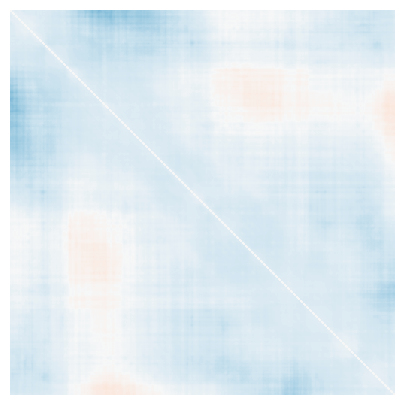

1


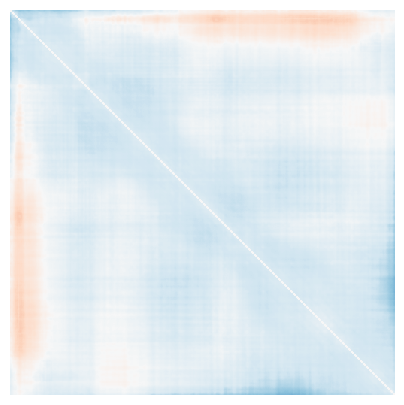

2


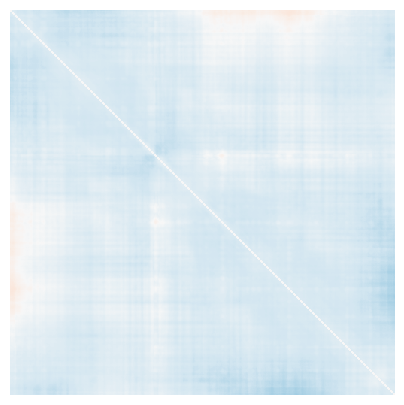

3


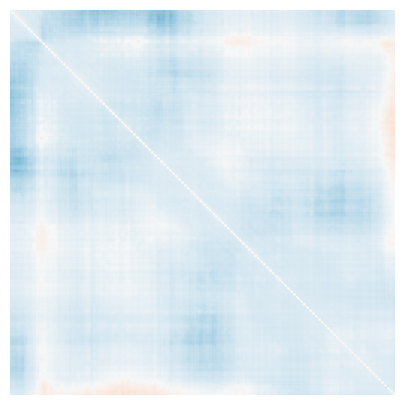

In [11]:
for i in range(4):
    print(i)
    reference_prediction_matrix = backgrounds_predictions[i, :, :]
    ref_maps = ut_dense(reference_prediction_matrix)
    
    fig = plt.figure(figsize=(5, 5))

    sns.heatmap(
        ref_maps[:,:,0],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    # plt.savefig(f"./example_maps/example_background_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"./example_maps/example_background_{i}.png", format="png", bbox_inches="tight")
    plt.show()

### Prediction for selected insertions

In [12]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [ ]:
num_experiments = len(seq_coords_df)

experiment 0
2/2 [==============================] - 11s 2s/step


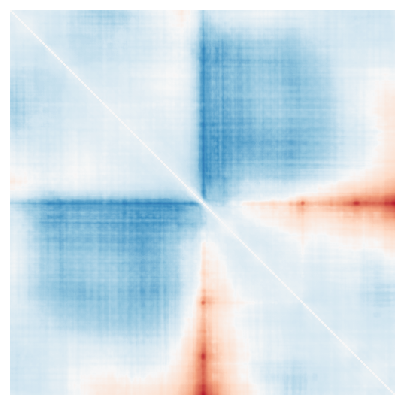

experiment 1


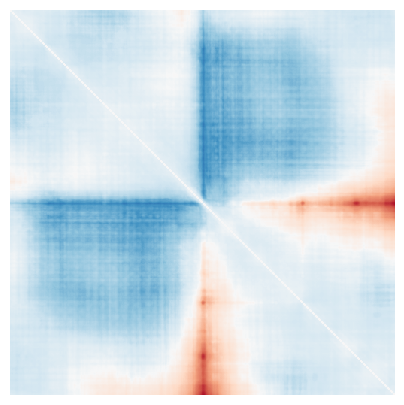

experiment 2


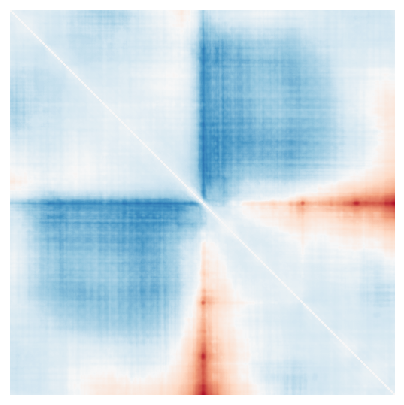

experiment 3


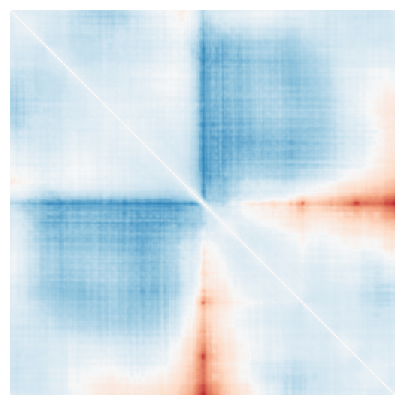

experiment 4


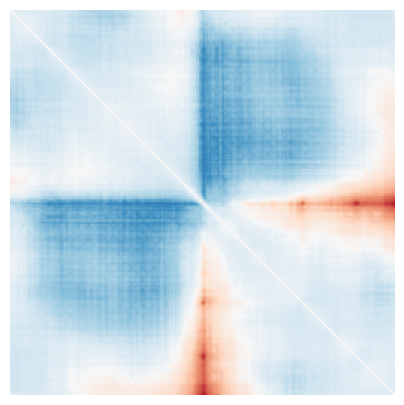

In [13]:
for exp_index in range(5):
    
    print(f"experiment {exp_index}")

    bg_index = seq_coords_df.iloc[exp_index].background_index

    prediction_matrix = preds_stream[exp_index]
    alt_maps_t0 = ut_dense(prediction_matrix)

    fig = plt.figure(figsize=(5, 5))

    sns.heatmap(
        alt_maps_t0[:,:,0],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    # plt.savefig(f"./example_plots/example_insertion_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"./example_maps/example_insertion_{exp_index}.png", format="png", bbox_inches="tight")
    plt.show()

In [14]:
genome_open.close()